# ServerSim Tutorial

*This document is a Jupyter notebook.  See http://jupyter.org/ for more information on Jupyter notebooks.*

## Introduction

This is a tutorial for ***[ServerSim](https://github.com/pvillela/ServerSim)***, a framework for the creation of discrete event simulation models to analyze the performance, throughput, and scalability of services deployed on computer servers.

Software engineers and architects not familiar with Python may want to jump directly to the *Simulations* section, skip the code, and focus on the simulation definitions and conclusions.

## Tutorial Example: Comparison of Two Service Deployment Patterns

Below we compare two major service deployment patterns by using discrete-event simulations. Ideally the reader will have had some prior exposure to the Python language in order to follow along all the details.  However, the concepts and conclusions should be understandable to readers with software architecture or engineering background even if not familiar with Python.

We assume an application made up of multiple multi-threaded services and consider two deployment patterns:

- **Cookie-cutter deployment**, where all services making up an application are deployed together on each physical or virtual server.  Each service may be deployed as a process or as a container.  The determining characteristic of this deployment approach is that services deployed on a server do not have compartmentalized allocations of computational capacity and share the server's overall computational capacity.  This is typical for "monolithic" applications (see [Fowler](https://martinfowler.com/bliki/MicroservicePremium.html) and [Hammant](https://paulhammant.com/2011/11/29/cookie-cutter-scaling/)) but can also be used for micro-services.
- **Individualized deployment**, where each of the services is deployed on its own physical or virtual server (which may be a container).  The determining characteristic of this deployment approach is that services deployed on a server have individual compartmentalized allocations of computational capacity, so that one service's computations do not compete with other services' computations for capacity.

In the simulations below, the application is made up of just two services, to simplify the model and the analysis, but without loss of generality in terms of the main conclusions.

### Environment set-up

The code used in these simulations should be compatible with both Python 2.7 and Python 3.x.

Python and the following Python packages need to be installed in your computer:
- jupyter (to execute this notebook)
- simpy (simulation framework that ServerSim is based on)
- matplotlib (for plotting of graphs)
- pandas (for calculation of statistics)

The model in this document should be run from the parent directory of the `serversim` package directory, which contains the source files for the ServerSim framework.

### The core simulation function

Following is the the core function used in the simulations  This function will be called with different arguments to simulate different scenarios.

This function sets up a simulation with the following givens:

- Simulation duration of 200 time units (e.g., seconds).
- A set of servers.  Each server has 10 hardware threads, 20 software threads, and a speed of 20 compute units per unit of time.  The number of servers is fixed by the server_range1 and server_range2 parameters described below.
- Two services:
  - svc_1, which consumes a random number of compute units per request, with a range from 0.2 to 3.8, averaging 2.0 compute units per request
  - svc_2, which consumes a random number of compute units per request, with a range from 0.1 to 1.9, averaging 1.0 compute units per request
- A user group, with a number of users determined by the num_users parameter described below.  The user group generates service requests from the two services, with probabilities proportional to the parameters weight_1 and weight_2 described below.  The think time for users in the user group ranges from 2.0 to 10.0 time units.

#### Parameters:

- *num_users*: the number of users being simulated.  This parameter can be either a positive integer or a list of pairs.  In the second case, the list of pairs represents a number of users that varies over time as a step function.  The first elements of the pairs in the list must be strictly monotonically increasing and each pair in the list represents a step in the step function.  Each step starts (inclusive) at the time represented by the first component of the corresponding pair and ends (exclusive) at the time represented by the first component of the next pair in the list.
- *weight1*: the relative frequency of service requests for the first service.
- *weight2*: the relative frequency of service requests for the second service.
- *server_range1*: a Python range representing the numeric server IDs of the servers on which the first service can be deployed.
- *server_range2*: a Python range representing the numeric server IDs of the servers on which the second service can be deployed.  This and the above range can be overlapping.  In case they are overlapping, the servers in the intersection of the ranges will host both the first and the second service.

#### Imports

We import the required libraries, as well as the `__future__` import for compatibility between Python 2.7 and Python 3.x.


In [1]:
# %load simulate_deployment_scenario.py
from __future__ import print_function

from typing import List, Tuple, Sequence

from collections import namedtuple
import random

import simpy

from serversim import *


def simulate_deployment_scenario(num_users, weight1, weight2, server_range1,
                                 server_range2):
    # type: (int, float, float, Sequence[int], Sequence[int]) -> Result

    Result = namedtuple("Result", ["num_users", "weight1", "weight2", "server_range1",
                         "server_range2", "servers", "grp"])

    def cug(mid, delta):
        """Computation units generator"""
        def f():
            return random.uniform(mid - delta, mid + delta)
        return f

    def ld_bal(svc_name):
        """Application server load-balancer."""
        if svc_name == "svc_1":
            svr = random.choice(servers1)
        elif svc_name == "svc_2":
            svr = random.choice(servers2)
        else:
            assert False, "Invalid service type."
        return svr

    simtime = 200
    hw_threads = 10
    sw_threads = 20
    speed = 20
    svc_1_comp_units = 2.0
    svc_2_comp_units = 1.0
    quantiles = (0.5, 0.95, 0.99)

    env = simpy.Environment()

    n_servers = max(server_range1[-1] + 1, server_range2[-1] + 1)
    servers = [Server(env, hw_threads, sw_threads, speed, "AppServer_%s" % i)
               for i in range(n_servers)]
    servers1 = [servers[i] for i in server_range1]
    servers2 = [servers[i] for i in server_range2]

    svc_1 = CoreSvcRequester(env, "svc_1", cug(svc_1_comp_units,
                                               svc_1_comp_units*.9), ld_bal)
    svc_2 = CoreSvcRequester(env, "svc_2", cug(svc_2_comp_units,
                                               svc_2_comp_units*.9), ld_bal)

    weighted_txns = [(svc_1, weight1),
                     (svc_2, weight2)
                     ]

    min_think_time = 2.0  # .5 # 4
    max_think_time = 10.0  # 1.5 # 20
    svc_req_log = []  # type: List[Tuple[str, SvcRequest]]

    grp = UserGroup(env, num_users, "UserTypeX", weighted_txns, min_think_time,
                    max_think_time, quantiles, svc_req_log)
    grp.activate_users()

    env.run(until=simtime)

    return Result(num_users=num_users, weight1=weight1, weight2=weight2,
            server_range1=server_range1, server_range2=server_range2,
            servers=servers, grp=grp)


### Printing the simulation results

The following function prints the outputs from the above core simulation function.

In [2]:
# %load print_results.py
from __future__ import print_function

from typing import Sequence, Any, IO

from serversim import *


def print_results(num_users=None, weight1=None, weight2=None, server_range1=None,
                  server_range2=None, servers=None, grp=None, fi=None):
    # type: (int, float, float, Sequence[int], Sequence[int], Sequence[Server], UserGroup, IO[str]) -> None
    
    if fi is None:
        import sys
        fi = sys.stdout

    print("\n\n***** Start Simulation --", num_users, ",", weight1, ",", weight2, ", [", server_range1[0], ",", server_range1[-1] + 1,
          ") , [", server_range2[0], ",", server_range2[-1] + 1, ") *****", file=fi)
    print("Simulation: num_users =", num_users, file=fi)

    print("<< ServerExample >>\n", file=fi)

    indent = " " * 4

    print("\n" + "Servers:", file=fi)
    for svr in servers:
        print(indent*1 + "Server:", svr.name, file=fi)
        print(indent * 2 + "max_concurrency =", svr.max_concurrency, file=fi)
        print(indent * 2 + "num_threads =", svr.num_threads, file=fi)
        print(indent*2 + "speed =", svr.speed, file=fi)
        print(indent * 2 + "avg_process_time =", svr.avg_process_time, file=fi)
        print(indent * 2 + "avg_hw_queue_time =", svr.avg_hw_queue_time, file=fi)
        print(indent * 2 + "avg_thread_queue_time =", svr.avg_thread_queue_time, file=fi)
        print(indent * 2 + "avg_service_time =", svr.avg_service_time, file=fi)
        print(indent * 2 + "avg_hw_queue_length =", svr.avg_hw_queue_length, file=fi)
        print(indent * 2 + "avg_thread_queue_length =", svr.avg_thread_queue_length, file=fi)
        print(indent * 2 + "hw_queue_length =", svr.hw_queue_length, file=fi)
        print(indent * 2 + "hw_in_process_count =", svr.hw_in_process_count, file=fi)
        print(indent * 2 + "thread_queue_length =", svr.thread_queue_length, file=fi)
        print(indent * 2 + "thread_in_use_count =", svr.thread_in_use_count, file=fi)
        print(indent*2 + "utilization =", svr.utilization, file=fi)
        print(indent*2 + "throughput =", svr.throughput, file=fi)

    print(indent*1 + "Group:", grp.name, file=fi)
    print(indent*2 + "num_users =", grp.num_users, file=fi)
    print(indent*2 + "min_think_time =", grp.min_think_time, file=fi)
    print(indent*2 + "max_think_time =", grp.max_think_time, file=fi)
    print(indent * 2 + "responded_request_count =", grp.responded_request_count(None), file=fi)
    print(indent * 2 + "unresponded_request_count =", grp.unresponded_request_count(None), file=fi)
    print(indent * 2 + "avg_response_time =", grp.avg_response_time(), file=fi)
    print(indent * 2 + "std_dev_response_time =", grp.std_dev_response_time(None), file=fi)
    print(indent*2 + "throughput =", grp.throughput(None), file=fi)

    for svc in grp.svcs:
        print(indent*2 + svc.svc_name + ":", file=fi)
        print(indent * 3 + "responded_request_count =", grp.responded_request_count(svc), file=fi)
        print(indent * 3 + "unresponded_request_count =", grp.unresponded_request_count(svc), file=fi)
        print(indent * 3 + "avg_response_time =", grp.avg_response_time(svc), file=fi)
        print(indent * 3 + "std_dev_response_time =", grp.std_dev_response_time(svc), file=fi)
        print(indent*3 + "throughput =", grp.throughput(svc), file=fi)


### Mini-batching, plotting, and comparison of results

The following three functions handle mini-batching, plotting, and comparison of results.

- ***minibatch_resp_times*** -- This function takes the user group from the results of the deployment_example function, scans the service request log of the user group, and produces mini-batch statistics for every time_resolution time units.  For example, with a simulation of 200 time units and a time_resolution of 5 time units, we end up with 40 mini-batches.  The statistics produced are the counts, means, medians, 95th percentile, and 99th percentile in each mini-batch.
- ***plot_counts_means_q95*** -- Plots superimposed counts, means, and 95th percentiles for two mini-batch sets coming from two simulation scenarios.
- ***compare_scenarios*** -- Combines the above two functions to produce comparison plots from two simulation scenarios.

In [3]:
# %load report_resp_times.py
from typing import TYPE_CHECKING
from collections import OrderedDict, namedtuple

import matplotlib.pyplot as plt
import pandas as pd

if TYPE_CHECKING:
    from serversim import UserGroup


Minibatch = namedtuple("Result", ["ts", "counts", "means", "q_95"])


def minibatch_resp_times(time_resolution, grp):
    # type: (float, UserGroup) -> Minibatch

    times = ((svc_req.time_dict["submitted"] // time_resolution) *
             time_resolution
             for (_, svc_req) in grp.svc_req_log
             if svc_req.is_completed)

    vals = (svc_req.time_dict["completed"] - svc_req.time_dict["submitted"]
            for (_, svc_req) in grp.svc_req_log
            if svc_req.is_completed)

    series = pd.Series(vals, index=times)
    grouped = series.groupby(level=0)

    counts_ser = grouped.count()
    ts = counts_ser.index.values
    counts = counts_ser.values
    means = grouped.mean().values
    q_95 = grouped.quantile(.95).values

    return Minibatch(ts, counts, means, q_95)


def plot_counts_means_q95(minibatch1, minibatch2):
    # type: (Minibatch, Minibatch) -> None

    x = minibatch1.ts  # should be same as minibatch2.ts

    counts1 = minibatch1.counts
    counts2 = minibatch2.counts

    means1 = minibatch1.means
    means2 = minibatch2.means

    q1_95 = minibatch1.q_95
    q2_95 = minibatch2.q_95

    fig = plt.figure(figsize=(10, 9))  # size in inches
    grid = plt.GridSpec(2, 3, hspace=0.25)

    # Plot counts
    axc = fig.add_subplot(grid[0, :-1])
    axc.plot(x, counts1, color='b', label="Counts 1")
    axc.plot(x, counts2, color='r', label="Counts 2")
    axc.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axc.set_xlabel("Time buckets")
    axc.set_ylabel("Throughput")

    # Plot response time averages and 95th percentiles
    axr = fig.add_subplot(grid[1, :-1])
    axr.plot(x, means1, color='b', label="Means 1")
    axr.plot(x, q1_95, color='c', label="95th Percentile 1")
    axr.plot(x, means2, color='r', label="Means 2")
    axr.plot(x, q2_95, color='m', label="95th Percentile 2")
    axr.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axr.set_xlabel("Time buckets")
    axr.set_ylabel("Response times")

    plt.show()

    
def compare_scenarios(sc1, sc2):
    grp1 = sc1.grp
    grp2 = sc2.grp

    minibatch1 = minibatch_resp_times(5, grp1)
    minibatch2 = minibatch_resp_times(5, grp2)

    plot_counts_means_q95(minibatch1, minibatch2)


### Random number generator seed

We set the random number generator seed to a known value to produce repeatable simulations.  Comment-out this line to have a different system-generated seed every time the simulations are executed.

In [4]:
random.seed(123456)

### Simulations

Several simulation scenarios are executed below.  See the descriptions of the parameters and hard-coded given values of the core simulation function above.

With 10 servers and weight_1 = 2 and weight_2 = 1, this configuration supports 720 users with average response times close to the minimum possible.  How did we arrive at that number?  For svc_1, the heavier of the two services, the minimum possible average response time is 1 time unit (= 20 server compute units / 10 hardware threads / 2 average service compute units).  One server can handle 10 concurrent svc_1 users without think time, or 60 concurrent svc_1 users with average think time of 6 time units.  Thus, 10 servers can handle 600 concurrent svc_1 users.  Doing the math for both services and taking their respective probabilities into account, the number of users is 720.  For full details, see the spreadsheet [CapacityPlanning.xlsx](https://github.com/pvillela/ServerSim/blob/master/CapacityPlanning.xlsx).  Of course, due to randomness, there will be queuing and the average response times will be greater than the minimum possible.  With these numbers, the servers will be running *hot* as there is no planned slack capacity.


#### Simulation 0

This is a simulation of one scenario (not a comparison) and printing out of its results.  It illustrates the use of the print_results function.  The scenario here is the same as the first scenario for Simulation 1 below.

In [5]:
sc1 = simulate_deployment_scenario(num_users=720, weight1=2, weight2=1, 
                                   server_range1=range(0, 10), server_range2=range(0, 10))
print_results(**sc1.__dict__)



***** Start Simulation -- 720 , 2 , 1 , [ 0 , 10 ) , [ 0 , 10 ) *****
Simulation: num_users = 720
<< ServerExample >>


Servers:
    Server: AppServer_0
        max_concurrency = 10
        num_threads = 20
        speed = 20
        avg_process_time = 0.846180691609
        avg_hw_queue_time = 0.2101130285
        avg_thread_queue_time = 0.0591755936664
        avg_service_time = 1.10295158856
        avg_hw_queue_length = 2.06856276558
        avg_thread_queue_length = 0.582583719646
        hw_queue_length = 10
        hw_in_process_count = 10
        thread_queue_length = 15
        thread_in_use_count = 20
        utilization = 0.833064890889
        throughput = 9.845
    Server: AppServer_1
        max_concurrency = 10
        num_threads = 20
        speed = 20
        avg_process_time = 0.813498888851
        avg_hw_queue_time = 0.145477017523
        avg_thread_queue_time = 0.00782950371385
        avg_service_time = 0.966805410088
        avg_hw_queue_length = 1.4220378462

#### Simulation 1

In the first scenario, there are 10 servers which are shared by both services.  In the second scenario, there are 10 servers, of which 8 are allocated to the first service and 2 are allocated to the second service.  This allocation is proportional to their respective loads.

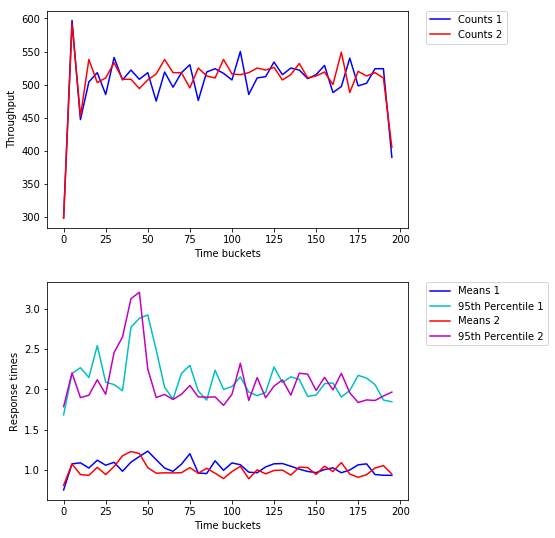

In [6]:
rand_state = random.getstate()
sc1 = simulate_deployment_scenario(num_users=720, weight1=2, weight2=1, 
                                   server_range1=range(0, 10), server_range2=range(0, 10))

random.setstate(rand_state)
sc2 = simulate_deployment_scenario(num_users=720, weight1=2, weight2=1, 
                                   server_range1=range(0, 8), server_range2=range(8, 10))
compare_scenarios(sc1, sc2)

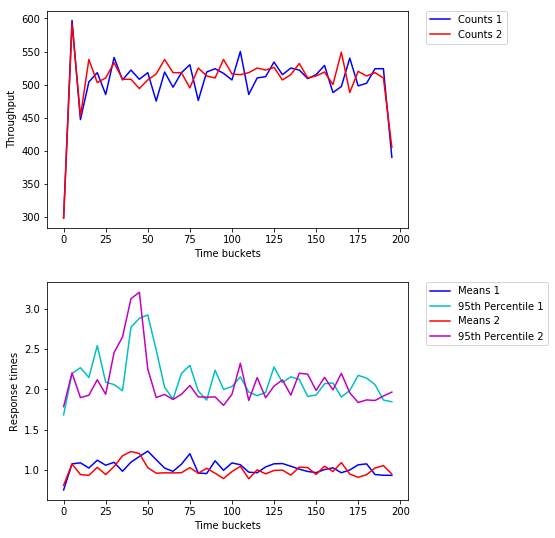

In [7]:
compare_scenarios(sc1, sc2)

Repeating above comparison to illustrate variability of results.

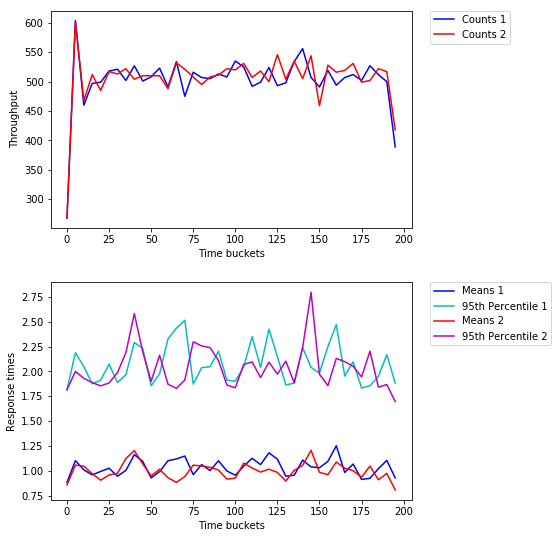

In [8]:
rand_state = random.getstate()
sc1 = simulate_deployment_scenario(num_users=720, weight1=2, weight2=1, 
                                   server_range1=range(0, 10), server_range2=range(0, 10))
random.setstate(rand_state)
sc2 = simulate_deployment_scenario(num_users=720, weight1=2, weight2=1, 
                                   server_range1=range(0, 8), server_range2=range(8, 10))
compare_scenarios(sc1, sc2)

***Conclusions:*** The results of the two deployment strategies are similar in terms of throughput, mean response times, and 95th percentile response times.  This is as would be expected, since the capacities allocated under the individualized deployment strategy are proportional to the respective service loads.

#### Simulation 2

Now, we change the weights of the different services, significantly increasing the weight of svc_1 from 2 to 5.

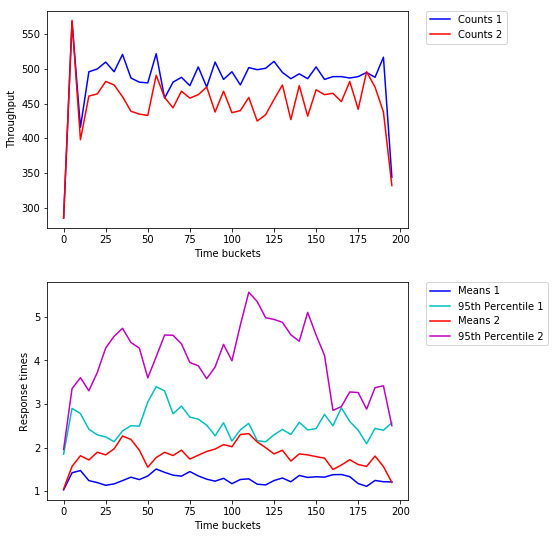

In [9]:
rand_state = random.getstate()
sc1 = simulate_deployment_scenario(num_users=720, weight1=5, weight2=1, 
                                   server_range1=range(0, 10), server_range2=range(0, 10))
random.setstate(rand_state)
sc2 = simulate_deployment_scenario(num_users=720, weight1=5, weight2=1, 
                                   server_range1=range(0, 8), server_range2=range(8, 10))
compare_scenarios(sc1, sc2)

***Conclusions:*** The cookie-cutter deployment strategy was able to absorb the change in load mix, while the individualized strategy was not, with visibly lower throughput and higher mean and 95th percentile response times.

#### Simulation 3

For this simulation, we also change the weights of the two services, but now in the opposite direction -- we change the weight of svc_1 from 2 to 1.

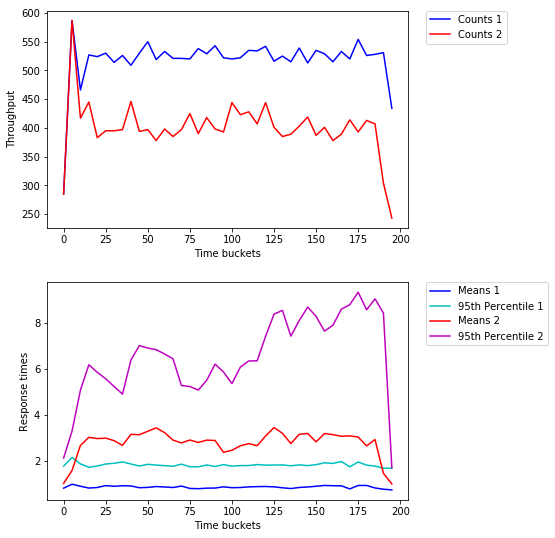

In [10]:
rand_state = random.getstate()
sc1 = simulate_deployment_scenario(num_users=720, weight1=1, weight2=1, 
                                   server_range1=range(0, 10), server_range2=range(0, 10))
random.setstate(rand_state)
sc2 = simulate_deployment_scenario(num_users=720, weight1=1, weight2=1, 
                                   server_range1=range(0, 8), server_range2=range(8, 10))
compare_scenarios(sc1, sc2)

***Conclusions:*** Again the cookie-cutter deployment strategy was able to absorb the change in load mix, while the individualized strategy was not, with visibly lower throughput and higher mean and 95th percentile response times.  Notice that due to the changed load mix, the total load was lower than before and, with the same number of servers, the cookie-cutter configuration had excess capacity while the individualized configuration had excess capacity for svc_1 and insufficient capacity for svc_2.

#### Simulation 4

We now continue with the weights used in Simulation 3, but adjust server capacity to account for the lower aggregate load and different load mix.  

Below we have three scenarios:
- Scenario 1 (cookie-cutter) removes one server
- Scenario 2 (individualized) removes one server from the pool allocated to svc_1
- Scenario 3 (individualized) removes one server and reassigns one server from the svc_1 pool to the svc_2 pool.

Run the three scenarios:

In [11]:
rand_state = random.getstate()
sc1 = simulate_deployment_scenario(num_users=720, weight1=1, weight2=1, 
                                   server_range1=range(0, 9), server_range2=range(0, 9))
random.setstate(rand_state)
sc2a = simulate_deployment_scenario(num_users=720, weight1=1, weight2=1, 
                                    server_range1=range(0, 7), server_range2=range(7, 9))
random.setstate(rand_state)
sc2b = simulate_deployment_scenario(num_users=720, weight1=1, weight2=1, 
                                    server_range1=range(0, 6), server_range2=range(6, 9))

Compare the results of scenarios 1 and 2a:

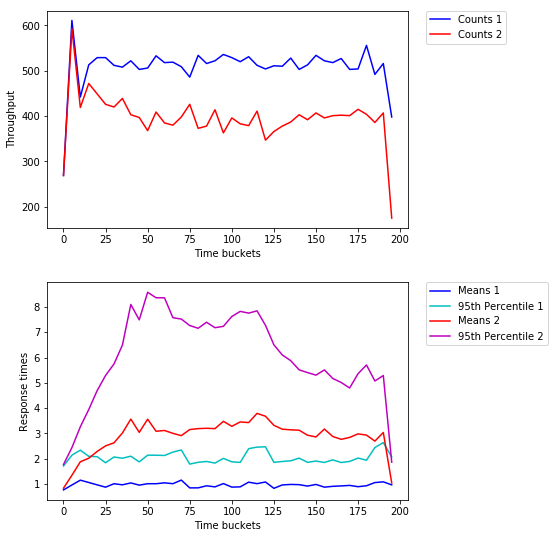

In [12]:
compare_scenarios(sc1, sc2a)

Compare the results of scenarios 1 and 2b:

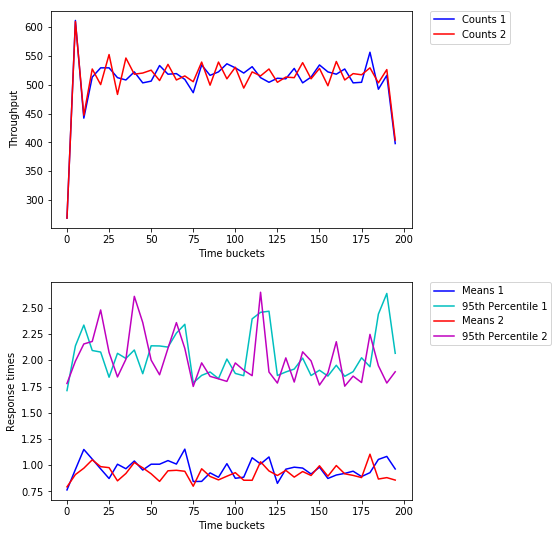

In [13]:
compare_scenarios(sc1, sc2b)

***Conclusions:*** Scenario 1 performs significantly than better Scenario 2a and comparably to Scenario 2b.  This simulation shows again that the cookie-cutter strategy is comparable in performance and throughput to a tuned individualized configuration, and beats hands-down an individualized configuration that is not perfectly tuned for the load mix.

#### Vary the number of users over time

The simulations below will vary the load over time by varying the number of users over time.  The list below defines a step function the represents the number of users varying over time.  In this case, the number of users changes every 50 time units.

In [14]:
users_curve = [(0, 900), (50, 540), (100, 900), (150, 540)]

#### Simulation 5

This simulation is similar to Simulation 1, the difference being the users curve instead of a constant 720 users.

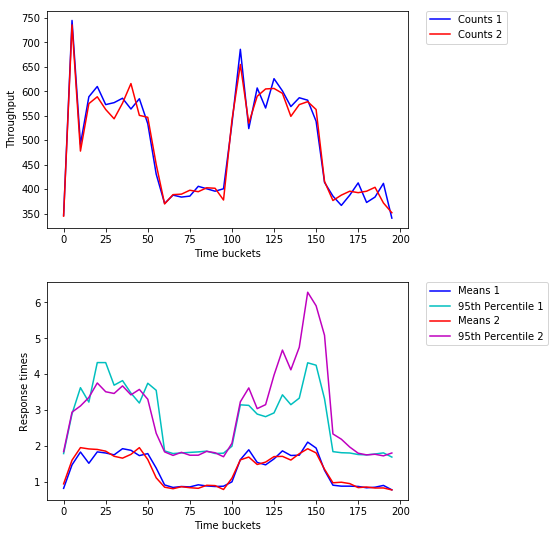

In [15]:
rand_state = random.getstate()
sc1 = simulate_deployment_scenario(num_users=users_curve, weight1=2, weight2=1, 
                                   server_range1=range(0, 10), server_range2=range(0, 10))
random.setstate(rand_state)
sc2 = simulate_deployment_scenario(num_users=users_curve, weight1=2, weight2=1, 
                                   server_range1=range(0, 8), server_range2=range(8, 10))
compare_scenarios(sc1, sc2)

***Conclusions:*** The cookie-cutter and individualized strategies produced similar results.

#### Simulation 6

We now run a simulation similar to Simulation 4, with the difference that the number of users varies over time.  This combines load variability over time as well as a change in load mix.  As in Simulation 4, we adjust server capacity to account for the lower aggregate load and different load mix.  

Below we have three scenarios:
- Scenario 1 (cookie-cutter) removes one server
- Scenario 2a (individualized) removes one server from the pool allocated to svc_1
- Scenario 2b (individualized) removes one server and reassigns one server from the svc_1 pool to the svc_2 pool.

Run the three scenarios:

In [16]:
rand_state = random.getstate()
sc1 = simulate_deployment_scenario(num_users=users_curve, weight1=1, weight2=1, 
                                   server_range1=range(0, 9), server_range2=range(0, 9))
random.setstate(rand_state)
sc2a = simulate_deployment_scenario(num_users=users_curve, weight1=1, weight2=1, 
                                    server_range1=range(0, 7), server_range2=range(7, 9))
random.setstate(rand_state)
sc2b = simulate_deployment_scenario(num_users=users_curve, weight1=1, weight2=1, 
                                    server_range1=range(0, 6), server_range2=range(6, 9))

Compare the results of scenarios 1 and 2a:

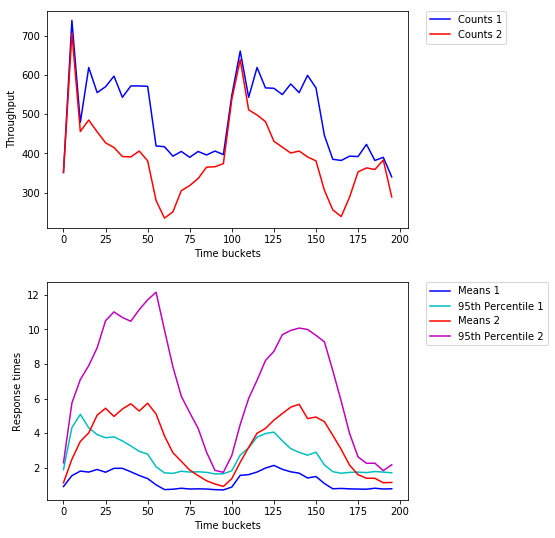

In [17]:
compare_scenarios(sc1, sc2a)

Compare the results of scenarios 1 and 2b:

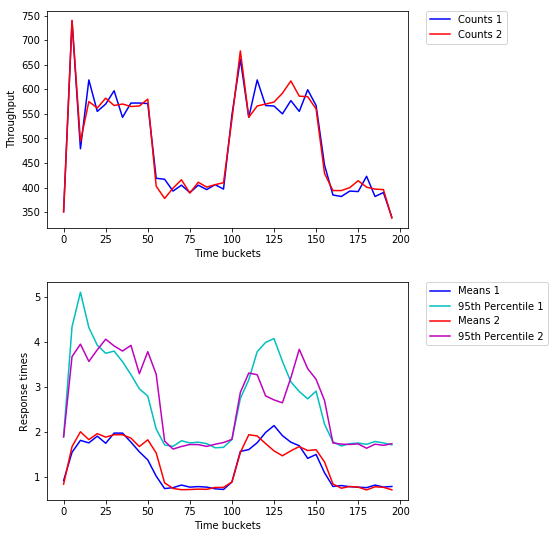

In [18]:
compare_scenarios(sc1, sc2b)

***Conclusions:*** Scenario 1 performs significantly better than Scenario 2a and comparably to Scenario 2b.  This simulation shows again that the cookie-cutter strategy is comparable in performance and throughput to a tuned individualized configuration, and beats an individualized configuration that is not perfectly tuned for the load mix.

#### Simulation 7

This final simulation is similar to Simulation 1, with the difference that the number of users is 864 instad of 720.  In this scenario, the total number of servers required for best capacity utilization can be calculated to be 12 (see [CapacityPlanning.xlsx](https://github.com/pvillela/ServerSim/blob/master/CapacityPlanning.xlsx)).  Under the individualized deployment strategy, the ideal number of servers allocated to svc_1 and svc_2 would be 9.6 and 2.4, respectively.  Since the number of servers needs to be an integer, we will run simulations with server allocations to svc_1 and svc_2, respectively, of 10 and 2, 9 and 3, and 10 and 3.

Thus, we have five scenarios:
- Scenario 1a (cookie-cutter) with 12 servers
- Scenario 2a1 (individualized) with 9 servers for svc_1 and 3 servers for svc_2
- Scenario 2a2 (individualized) with 10 servers for svc_1 and 2 servers for svc_2
- Scenario 1b (cookie-cutter) with 13 servers
- Scenario 2b (individualized) with 10 servers for svc_1 and 3 servers for svc_2

Run the scenarios:

In [19]:
rand_state = random.getstate()
sc1a = simulate_deployment_scenario(num_users=864, weight1=2, weight2=1, 
                                server_range1=range(0, 12), server_range2=range(0, 12))
random.setstate(rand_state)
sc2a1 = simulate_deployment_scenario(num_users=864, weight1=2, weight2=1, 
                                server_range1=range(0, 9), server_range2=range(9, 12))
random.setstate(rand_state)
sc2a2 = simulate_deployment_scenario(num_users=864, weight1=2, weight2=1, 
                                server_range1=range(0, 10), server_range2=range(10, 12))
random.setstate(rand_state)
sc1b = simulate_deployment_scenario(num_users=864, weight1=2, weight2=1, 
                                server_range1=range(0, 13), server_range2=range(0, 13))
random.setstate(rand_state)
sc2b = simulate_deployment_scenario(num_users=864, weight1=2, weight2=1, 
                                server_range1=range(0, 10), server_range2=range(10, 13))

Compare the results of scenarios 1a and 2a1:

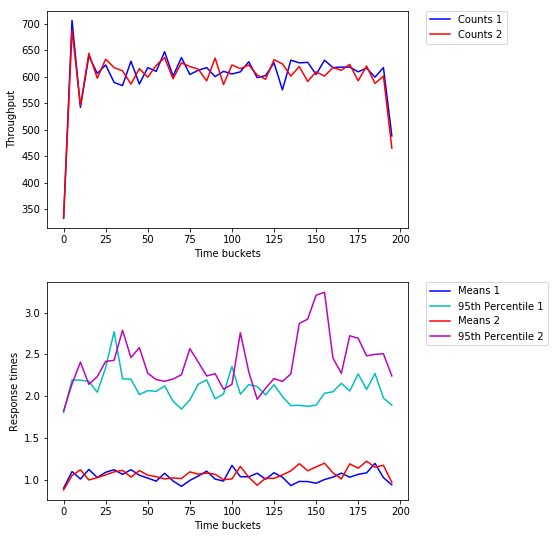

In [20]:
compare_scenarios(sc1a, sc2a1)

Compare the results of scenarios 1a and 2a2:

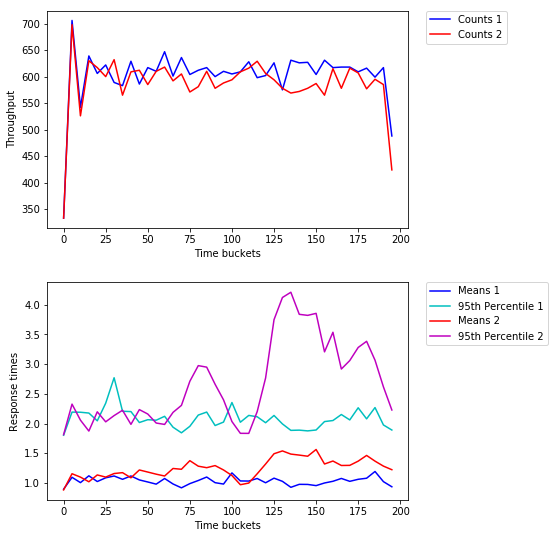

In [21]:
compare_scenarios(sc1a, sc2a2)

Compare the results of scenarios 1b and 2b:

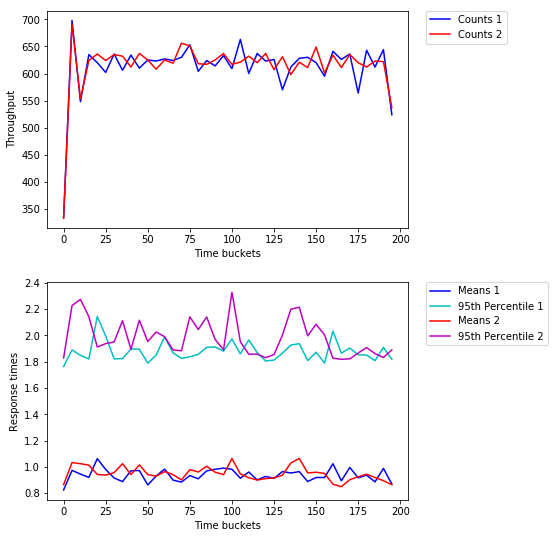

In [22]:
compare_scenarios(sc1b, sc2b)

***Conclusions:*** Scenario 1a has comparable throughput but somewhat better response times than Scenario 2a1.  Scenario 1a has somewhat better throughput and response times than Scenario 2a2.  Scenario 1b has comparable throughput and a bit less extreme response times than Scenario 2b.  In all three comparisons, the cookie-cutter strategy performs better than or comparably to the individualized strategy.

#### Overall Conclusions

The various simulations show consistently that the cookie-cutter strategy is comparable in performance and throughput (and therefore hardware utilization) to a tuned individualized configuration, and beats an individualized configuration that is not well-tuned for the load mix.  Cookie-cutter thus proves to be a more robust and stable deployment strategy in many realistic situations, in the face of likely load mix fluctuations, mismatches between forecast average load mixes and actual average load mixes, and mismatches between forecast load mixes and allocated server capacities.  However, although not highlighted on the simulation graphs presented, it is a fact (that can be observed in the simulation logs) that response times for svc_2 are better under a well-tuned individualized configuration because then svc_2 requests don't have to share a queue with longer-running svc_1 requests.  When that's an important consideration, an individualized deployment strategy could be a more appropriate choice.